# Dataset
IMDb-Wiki - paczka danych .mat (Matlab), zawiera ponad 500k zdjęć i ich metadanych (m.in. wiek osoby na zdjęciu):

https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/

Przetworzenie danych:
*   zapis z pliku .mat do .csv
*   usunięcie błędnych i brakujących danych
*   zmiana rozmiaru zdjęć


### Załadowanie dysku

In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
path_dir = r'/content/drive/My Drive/colab_files/imdb/'

Mounted at /content/drive


*italicized text*### Zapisanie danych do pliku csv

In [0]:
# Rozpakowanie danych
import numpy as np
from scipy.io import loadmat
import pandas as pd
import datetime as date
from dateutil.relativedelta import relativedelta

cols = ['age', 'gender', 'path', 'face_score1', 'face_score2']

wiki_mat = path_dir + 'imdb.mat' 
wiki_data = loadmat(wiki_mat)

del wiki_mat

wiki = wiki_data['imdb'] 

wiki_photo_taken = wiki[0][0][1][0]
wiki_full_path = wiki[0][0][2][0]
wiki_gender = wiki[0][0][3][0]
wiki_face_score1 = wiki[0][0][6][0]
wiki_face_score2 = wiki[0][0][7][0]

wiki_path = []

for path in wiki_full_path:
    wiki_path.append(path[0])

wiki_genders = []

for n in range(len(wiki_gender)):
    if wiki_gender[n] == 1:
        wiki_genders.append('male')
    else:
        wiki_genders.append('female')

wiki_dob = []

wiki_age = []

for file in wiki_path:
    d1 = file.split('_')[2]
    d1 = d1.split('-')[0]
    d2 = file.split('_')[-1][:-4]
    diff = int(d2) - int(d1)
    wiki_age.append(diff)

final_wiki = np.vstack((wiki_age, wiki_genders, wiki_path, wiki_face_score1, wiki_face_score2)).T

final_wiki_df = pd.DataFrame(final_wiki)

final_wiki_df.columns = cols

meta = final_wiki_df

meta = meta.drop(['face_score1', 'face_score2'], axis=1)
cond = meta[meta['age'] == '-1'].index
meta.drop(cond, inplace=True)

print(meta)

meta = meta.sample(frac=1)

meta.to_csv(path_dir + 'meta.csv', index=False)

print('\n\nWriting to csv file done') 

       age  gender                                          path
0       69    male   01/nm0000001_rm124825600_1899-5-10_1968.jpg
1       71    male  01/nm0000001_rm3343756032_1899-5-10_1970.jpg
2       69    male   01/nm0000001_rm577153792_1899-5-10_1968.jpg
3       69    male   01/nm0000001_rm946909184_1899-5-10_1968.jpg
4       69    male   01/nm0000001_rm980463616_1899-5-10_1968.jpg
...     ..     ...                                           ...
460718  22  female  08/nm3994408_rm761245696_1989-12-29_2011.jpg
460719  22  female  08/nm3994408_rm784182528_1989-12-29_2011.jpg
460720  22  female  08/nm3994408_rm926592512_1989-12-29_2011.jpg
460721  22  female  08/nm3994408_rm943369728_1989-12-29_2011.jpg
460722  22  female  08/nm3994408_rm976924160_1989-12-29_2011.jpg

[460693 rows x 3 columns]


Writing to csv file done


### Podzielenie danych na dane testowe i walidacyjne + zmiana rozmiarów zdjęć + przygotowanie nowych plików csv

In [0]:
import cv2
import os
from sklearn.model_selection import train_test_split
import csv
import pandas as pd

# Załadowanie pliku csv
meta = pd.read_csv(path_dir + 'meta.csv')
meta = meta.drop(['gender'], axis=1)
meta = meta.values

# Podział na dane trenignowe i walidacyjne
D_train, D_test = train_test_split(meta, test_size=0.2, random_state=42)
print('Found', len(D_train), 'learning photos and', len(D_test), 'testing photos in csv file')

# Nowe pliki csv
cols = ['filepath', 'age']
train_csv = [cols]
test_csv = [cols]

# Utworzenie folderów
dataset_train_path = path_dir + 'dataset/train/'
for i in range(5):
    output_dir_train = dataset_train_path + '0' + str(i)
    if not os.path.exists(output_dir_train):
        os.makedirs(output_dir_train)

dataset_test_path = path_dir + 'dataset/test/'
for i in range(5):
    output_dir_test = dataset_test_path + '0' + str(i)
    if not os.path.exists(output_dir_test):
        os.makedirs(output_dir_test)

# Przerobienie zdjęć i zapis do nowych plików csv
counter = 0
for image in D_train:
    img_path = path_dir + image[1]
    img = cv2.imread(img_path, 1)
    if type(img) == 'NoneType':
      continue
    # try:
    #   img = cv2.resize(img, (256, 256))
    #   img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # except:
    #   continue
    # path_to_write = dataset_train_path + image[1]
    # try:
    #     cv2.imwrite(path_to_write, img)
    # except:
    #     continue
    counter += 1
    path_to_write = img_path
    line = [path_to_write, image[0]]
    train_csv.append(line)
print('Processed', counter, 'training photos')

counter = 0
for image in D_test:
    img_path = path_dir + image[1]
    img = cv2.imread(img_path, 1)
    if type(img) == 'NoneType':
        continue
    # try:
    #   img = cv2.resize(img, (256, 256))
    #   img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # except:
    #   continue
    # path_to_write = dataset_test_path + image[1]
    # try:
    #     cv2.imwrite(path_to_write, img)
    # except:
    #     continue
    counter += 1
    path_to_write = img_path
    line = [path_to_write, image[0]]
    test_csv.append(line)
print('Processed', counter, 'testing photos')

# Zapis plików csv
with open(path_dir + 'train.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(train_csv)

with open(path_dir + 'test.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(test_csv)

print('Done')

Found 368554 learning photos and 92139 testing photos in csv file
Processed 368554 training photos
Processed 92139 testing photos
Done


# Konwolucyjna sieć neuronowa

Teoria: https://adeshpande3.github.io/A-Beginner%27s-Guide-To-Understanding-Convolutional-Neural-Networks/

Konwolucyjna sieć neuronowa (inaczej splotowa, CNN) to szczególny przypadek jednokierunkowych sieci. Ich cechą charakterystyczną jest wykrywanie lokalnych wzorców, podczas gdy sieci MLP uczą się wzorców globalnych. Po otrzymaniu danych wejściowych, sieć konwolucyjna dzieli je na okna. Okno jest "przesuwane" wzdłuż danych wejściowych. Następnie wyodrębniony fragment jest mnożony przez macierz wag, nazywaną jądrem konwolucji. W efekcie z każdego fragmentu obrazu otrzymywany jest wektor wartości. Wektory ze wszystkich fragmentów układane są przestrzennie w nowy obraz, który jest wyjściem każdej warstwy. Z tego powodu warstwy sieci konwulcyjnych często nazywane są filtrami.

### Model sieci

Warstwy:

*   layers.Conv2d - warstwa konwolucyjna, definiuje się rozmiar okna (zazwyczaj 3x3 albo 5x5) i głębię jądra konwolucji

*   layers.MaxPooling2D - warstwa zmniejszająca rozmiar zdjęcia

Zdjęcie na wyjściu warstwy konwolucyjnej ma ten sam rozmiar, jak na wejściu, ale z większą głębią (równą głębi jądra). Żeby zmniejszyć rozmiar, stosuje się warstwę MaxPooling, która zmniejsza dwukrotnie rozmiar zdjęcia.

*    layers.Flatten - warstwa przekształcająca dane 2D (zdjęcie) na dane jednowymiarowe (takie są potrzebne na wejście warstw Dense)

*    layers.Dropout - odrzucanie, po polsku to dokładniej "technika regularyzacji opuszczeń" (ale nikt tego nie używa)

Odrzucanie to technika pozwalająca poprawić zdolność uogólniania sieci neuronowej. Polega to na tym, że mając na wejściu wektor 100 próbek i definiując współczynnik dropout na wartość np. 0,2, 20% losowych próbek z tego wektora zostanie wyzerowanych. Tę technikę można interpretować jako szum dodany do danych uczących, dzięki czemu sieć wychwytuje tylko istotne informacje, których szum nie zredukował. Zapobiega to przeuczaniu sieci neuronowej.

*    layers.Dense - warstwa gęsto połączonych neuronów (czyli taka zwykła jak w MLP)

Do Dense i Conv dodaje się parametr 'activation' który definiuje funkcję aktywacji (domyślnie jest None, czyli bez funkcji). Dodatkowo do pierwszej warstwy trzeba zdefiniować input_shape.

Sieci CNN definiuje się tak, żeby zdjęcie miało coraz mniejszy wymiar wysokości i szerokości przy coraz większej głębi, więc cała sieć składa się ze stosu warstw konwolucyjnych + warstw zmniejszających (np. MaxPooling) o coraz większej głębi jądra. Na końcu znajduje się co najmniej jedna warstwa Dense, która zawiera wyniki sieci.

Niedawno wyszła nowa wersja tensorflow (2.0), której Keras jeszcze nie obsługuje, więc importy muszą być przez tensorflow.keras zamiast keras


In [0]:
import tensorflow
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import model_from_json
import matplotlib.pyplot as plt
import pandas as pd

tar_size = 512
shape = (tar_size, tar_size, 3)

model = tensorflow.keras.Sequential()       # rodzaj modelu sieci

# 1. Warstwa konwolucyjna, rozmiar okna: 3x3, głębia jądra: 32
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=shape))
model.add(layers.MaxPooling2D((2, 2)))

# 2. Warstwa konwolucyjna, rozmiar okna: 3x3, głębia jądra: 64
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# 3. Warstwa konwolucyjna, rozmiar okna: 3x3, głębia jądra: 128
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# 4. Warstwa spłaszczająca dane (z 2D na 1D)
model.add(layers.Flatten())

# 5. Warstwa odrzucająca 20% danych
model.add(layers.Dropout(0.2))

# 6. Warstwa gęsta, 256 neuronów
model.add(layers.Dense(256, activation='relu'))

# 7. Warstwa wyjściowa - 1 neuron, bez funkcji aktywacji bo wyjściem ma być wartość wyjściowa (wiek)
model.add(layers.Dense(1))

# Funkcja printująca podsumowanie modelu sieci
model.summary()

# Optymalizator - Adam (prawie zawsze daje najlepsze wyniki)
optim = optimizers.Adam()

# Kompilacja modelu, loss - funkcja straty, metrics - metryka
# Funkcja straty: mse, czyli błąd średniokwadratowy, bo wyjściem jest liczba a nie klasa
# Metryka: mae, czyli średni błąd bezwględny, tak jak wyżej
model.compile(loss='mse', optimizer=optim, metrics=['mae'])

callbacks = [
				keras.callbacks.ModelCheckpoint(  		# zapisywanie najlepszego modelu
						filepath=path_dir + 'model_cnn.h5',
						monitor='val_loss',
						save_best_only=True,
				),

				keras.callbacks.EarlyStopping(      # zatrzymywanie uczenia po braku poprawy metryki
						monitor='mae',
						patience=4,
    		),

				keras.callbacks.ReduceLROnPlateau(      # poprawianie lr po utknięciu w minimum
						monitor='val_loss',
						factor=0.1,
						patience=4,
  		   ),
]

# Wczytanie danych do pandas df
path_dir = r'/content/drive/My Drive/colab_files/imdb/'
df = pd.read_csv(path_dir + 'train.csv', sep=',', header=0, names=['filepath', 'age'])
df_val = pd.read_csv(path_dir + 'test.csv', sep=',', header=0, names=['filepath', 'age'])

# Przetworzenie zdjęć z augumentacją, czyli "dorabianiem" nowych zdjęc
# dane treningowe
train_datagen = ImageDataGenerator(
												rescale=1./255,
												rotation_range=10,
												width_shift_range=0.2,
												height_shift_range=0.2,
												shear_range=0.2,
												zoom_range=0.2,
												horizontal_flip=True)

# dane testowe
test_datagen = ImageDataGenerator(rescale=1./255)

# Generatory do uczenia sieci
train_generator = train_datagen.flow_from_dataframe(
												dataframe=df,
												directory='',
												x_col='filepath',
												y_col='age',
												target_size=(tar_size, tar_size),
												batch_size=128,
												class_mode='raw',			)

validation_generator = test_datagen.flow_from_dataframe(
												dataframe=df_val,
												directory='',
												x_col='filepath',
												y_col='age',
												target_size=(tar_size, tar_size),
												batch_size=128,
												class_mode='raw',     )
	
# Wytrenowanie modelu
history = model.fit(
								train_generator,
								steps_per_epoch=20,
								epochs=30,
								validation_data=validation_generator,
								callbacks=callbacks)

# Wykres 
loss = history.history['loss']             
val_loss = history.history['val_loss']    
epochs = range(len(loss))

plt.figure()
plt.plot(epochs, loss, 'bo', label='Dane treningowe')
plt.plot(epochs, val_loss, 'b', label='Dane walidacyjne')
plt.title('Wartości funkcji straty procesu uczenia')
plt.xlabel('Epoki')
plt.ylabel('Wartość funkcji straty')
plt.legend()
plt.grid(True)

plt.show()

# Zapisanie modelu do pliku json (model) i h5 (wagi)
model_json = model.to_json()
with open(path_dir + 'model_cnn.json', 'w') as json_file:
    json_file.write(model_json)

# model.save_weights(path_dir + 'model_cnn.h5')
print('Saved model to disk')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 510, 510, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 255, 255, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 253, 253, 64)      18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 126, 126, 64)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 124, 124, 128)     73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 62, 62, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 60, 60, 256)      

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 353262 invalid image filename(s) in x_col="filepath". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 15292 validated image filenames.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 88399 invalid image filename(s) in x_col="filepath". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 3740 validated image filenames.
Epoch 1/50
30/30 [==============================] - ETA: 0s - loss: 919.1932 - mae: 22.3143 

### Wczytanie modelu

Wczytywanie modelu wytrenowanej sieci z plików json i h5 i testowanie sieci neuronowej

Loaded model from disk


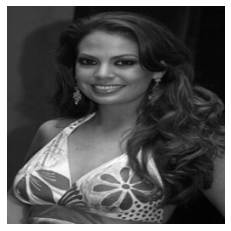

In [0]:
from tensorflow.keras.models import model_from_json

# Wczytanie modelu
json_file = open(path_dir + 'model_cnn.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights(path_dir + 'model_cnn.h5')
print('Loaded model from disk')

# Test
image = cv2.imread(path_dir + 'dataset/test/07/14853007_1984-05-07_2007.jpg')
image = cv2.resize(image, (tar_size, tar_size))
b,g,r = cv2.split(image)        # opencv ma format BGR, więc trzeba przekształcić na RGB
image2 = cv2.merge([r,g,b]) 
plt.imshow(image, cmap='gray')
plt.axis("off")
plt.show()

X = np.expand_dims(image, axis=[0,3])
y_pred = model.predict(X)[0][0]
print('Wiek: ', y_pred)

image = cv2.imread(path_dir + 'dataset/test/07/440507_1969-12-10_2014.jpg')
image = cv2.resize(image, (tar_size, tar_size)
b,g,r = cv2.split(image)        # opencv ma format BGR, więc trzeba przekształcić na RGB
image2 = cv2.merge([r,g,b]) 
plt.imshow(image, cmap='gray')
plt.axis("off")
plt.show()

X = np.expand_dims(image, axis=[0,3])
y_pred = model.predict(X)[0][0]
print('Wiek: ', y_pred)

## Inne rozwiązania

Można też użyć gotowych architektur, np. ResNet, albo częściowo wytrenowanych modeli jak InceptionV3.

Można też użyć funkcji z OpenCV, np. algorytm HaarCascade (znam tylko ten) 

### Inception V3


In [0]:
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras import optimizers
from tensorflow.keras.applications import inception_v3
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input as inception_v3_preprocessor

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

from tensorflow.keras.optimizers import Adam

import pandas as pd

tar_size = 299

# wczytanie modelu
base_model = InceptionV3(weights = 'imagenet', include_top = False, input_shape=(tar_size, tar_size, 3))

# dorobienie warstw wyjściowych
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(1, activation=None)(x)

# ostateczny model
model = Model(inputs = base_model.input, outputs = predictions)

# zamrożenie warstw
for layer in base_model.layers:
    layer.trainable = False

model.summary()

optim = optimizers.Adam()
model.compile(optim, loss='mse', metrics=['mae'])

callbacks = [
				keras.callbacks.ModelCheckpoint(  		# zapisywanie najlepszego modelu
						filepath=path_dir + 'model_inc.h5',
						monitor='val_loss',
						save_best_only=True,
				),

				keras.callbacks.EarlyStopping(      # zatrzymywanie uczenia po braku poprawy metryki
						monitor='mae',
						patience=4,
    		),

				keras.callbacks.ReduceLROnPlateau(      # poprawianie lr po utknięciu w minimum
						monitor='val_loss',
						factor=0.1,
						patience=4,
  		   ),
]

model_json = model.to_json()
with open(path_dir + 'model_inc.json', 'w') as json_file:
    json_file.write(model_json)

# Wczytanie danych do pandas df
df = pd.read_csv(path_dir + 'train.csv', sep=',', header=0, names=['filepath', 'age'])
df_val = pd.read_csv(path_dir + 'test.csv', sep=',', header=0, names=['filepath', 'age'])

# Przetworzenie zdjęć
# dane treningowe
train_datagen = ImageDataGenerator(rescale=1./255)

# dane testowe
test_datagen = ImageDataGenerator(rescale=1./255)

# Generatory do uczenia sieci
train_generator = train_datagen.flow_from_dataframe(
												dataframe=df,
												directory='',
												x_col='filepath',
												y_col='age',
												target_size=(tar_size, tar_size),
												batch_size=128,
												class_mode='raw',	
                        seed=10,	)

val_generator = test_datagen.flow_from_dataframe(
												dataframe=df_val,
												directory='',
												x_col='filepath',
												y_col='age',
												target_size=(tar_size, tar_size),
												batch_size=128,
												class_mode='raw',
                        seed=10,   )

history = model.fit_generator(train_generator,
                      steps_per_epoch = 175,
                      validation_data = val_generator,
                      validation_steps = 44,
                      epochs = 10,
                      verbose = 2,
                      callbacks = callbacks)

# Wykres 
loss = history.history['loss']             
val_loss = history.history['val_loss']    
epochs = range(len(loss))

plt.figure()
plt.plot(epochs, loss, 'bo', label='Dane treningowe')
plt.plot(epochs, val_loss, 'b', label='Dane walidacyjne')
plt.title('Wartości funkcji straty procesu uczenia')
plt.xlabel('Epoki')
plt.ylabel('Wartość funkcji straty')
plt.legend()
plt.grid(True)

plt.show()

# Zapisanie modelu do pliku json (model) i h5 (wagi)
model_json = model.to_json()
with open(path_dir + 'model_inc.json', 'w') as json_file:
    json_file.write(model_json)

model.save_weights(path_dir + 'model_inc.h5')
print('Saved model to disk')

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 353262 invalid image filename(s) in x_col="filepath". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 15292 validated image filenames.
Found 3740 validated image filenames.
Instructions for updating:
Please use Model.fit, which supports generators.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 88399 invalid image filename(s) in x_col="filepath". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Epoch 1/10


KeyboardInterrupt: ignored

Loaded model from disk


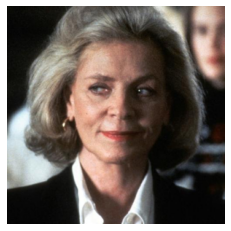

Wiek:  1742.9664


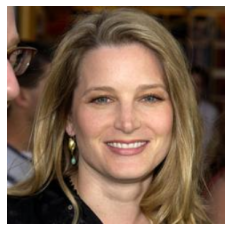

Wiek:  [[1035.0697]]


In [0]:
# Test
import cv2
from tensorflow.keras.models import model_from_json
import matplotlib.pyplot as plt
import numpy as np

tar_size = 299

# Wczytanie modelu
json_file = open(path_dir + 'model_inc.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights(path_dir + 'model_inc.h5')
print('Loaded model from disk')

# Test
image = cv2.imread(path_dir + '02/nm0000002_rm454874624_1924-9-16_1991.jpg')
image = cv2.resize(image, (tar_size, tar_size))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# b,g,r = cv2.split(image)        # opencv ma format BGR, więc trzeba przekształcić na RGB
# image2 = cv2.merge([r,g,b]) 
plt.imshow(image)
plt.axis("off")
plt.show()

X = np.expand_dims(image, axis=[0])
y_pred = model.predict(X)[0][0]
print('Wiek: ', y_pred)

image = cv2.imread(path_dir + '03/nm0000403_rm801150976_1964-1-27_2003.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (tar_size, tar_size))
# b,g,r = cv2.split(image)        # opencv ma format BGR, więc trzeba przekształcić na RGB
# image2 = cv2.merge([r,g,b]) 
plt.imshow(image)
plt.axis("off")
plt.show()

X = np.expand_dims(image, axis=[0])
y_pred = model.predict(X)[0][0]
print('Wiek: ', y_pred)